# Phishing URL Detection

### Initialisation

In [2]:
import pandas as pd
df = pd.read_csv('dataset.csv')
df.sample(5)

,URL,Label
321068,elyrics.net/read/t/toni-braxton-lyrics/take-th...,good
359602,imdb.com/name/nm1711322/news,good
393940,mtvnetworkscareers.com/burbank-ca-internship/,good
271503,allaboutjazz.com/php/musician.php?id=14591,good
25324,www.fmateco.com/~kayabest/sys/not/521499359863...,bad


### Description

In [3]:
df.describe()

,URL,Label
count,549346,549346
unique,507195,2
top,jhomitevd2abj3fk.tor2web.org/,good
freq,52,392924


### Remove Duplicates

In [4]:
df.drop_duplicates(inplace=True)
df.shape

(507196, 2)

### Remove Missing Values

In [5]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

### Dataset Information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507196 entries, 0 to 516470
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     507196 non-null  object
 1   Label   507196 non-null  object
dtypes: object(2)
memory usage: 11.6+ MB


### Dataset Subset

In [7]:
# df = df.sample(200000, random_state=42)
df_good = df[df['Label'] == 'good'].sample(150000, random_state=42)
df_bad = df[df['Label'] == 'bad'].sample(150000, random_state=42,replace=True)
df = pd.concat([df_good, df_bad])
del df_good,df_bad

### Add Useful Columns

In [14]:
import re
df['URL'] = [re.sub(r'^www.', '', x) for x in df['URL']]
df['no_of_dots'] = df['URL'].str.count('.')
df['no_of_dots'].value_counts()

no_of_dots
31     8854
33     6963
27     6797
26     5844
24     5831
       ... 
483       1
602       1
931       1
876       1
613       1
Name: count, Length: 558, dtype: int64

### Preprocessing

In [99]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = PorterStemmer()

def tokenize(sentence):
    tokens = tokenizer.tokenize(sentence)
    for token in tokens:
        token = stemmer.stem(token)
    return " ".join(tokens).strip()

df['URL_preprocessed'] = df['URL'].apply(tokenize)
df.head()

,URL,Label,URL_preprocessed
307795,collegefootball.org/famersearch.php?id=30006,good,collegefootball org famersearch php id
281308,answers.com/topic/virgil-thomson-classical-artist,good,answers com topic virgil thomson classical artist
72708,www.lowtek.com/sockets/,good,www lowtek com sockets
214632,monstertransmissionreviews.com/,good,monstertransmissionreviews com
62281,gotomy.com/color.html,good,gotomy com color html


### Vectorizing

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df['URL_preprocessed'])
Y = df['Label']
Y.replace({'bad':0,'good':1},inplace=True)

C:\Users\Rishabh\AppData\Local\Temp\ipykernel_24716\723267667.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y.replace({'bad':0,'good':1},inplace=True)


### Model Preparation

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Model Performance - Multinomial Naive Bayes

In [102]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
model = MultinomialNB()
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     30093
           1       0.96      0.96      0.96     29907

    accuracy                           0.96     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.96      0.96      0.96     60000



### Model Performance - Logistic Regression

In [103]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     30093
           1       0.95      0.97      0.96     29907

    accuracy                           0.96     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.96      0.96      0.96     60000



### Model Performance - XGBoost

In [104]:
from xgboost import XGBClassifier
vectorizer = TfidfVectorizer(max_features=50000,stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df['URL_preprocessed'])
Y = df['Label']
Y.replace({'bad':0,'good':1},inplace=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = XGBClassifier()
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88     30093
           1       0.85      0.94      0.89     29907

    accuracy                           0.89     60000
   macro avg       0.89      0.89      0.89     60000
weighted avg       0.89      0.89      0.89     60000



### Model Performance - Decision Tree

In [105]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     30093
           1       0.95      0.95      0.95     29907

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.95      0.95      0.95     60000



### Model Performance - ANN

In [106]:
del X,Y,X_train,X_test,Y_train,Y_test,model,hist,Y_pred,vectorizer,tokenizer,stemmer

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=10000,stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df['URL_preprocessed'])
Y = df['Label']
Y.replace({'bad':0,'good':1},inplace=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1, mode='auto', min_delta=0.0001)
X_train = X_train.astype('float32')

model = Sequential()
model.add(Dense(128, input_dim=10000, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train.toarray(), Y_train, epochs=5, batch_size=64, callbacks=[callback], validation_split=0.2)

MemoryError: Unable to allocate 8.94 GiB for an array with shape (240000, 10000) and data type float32

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
Y_prob = model.predict(X_test.toarray())
Y_pred = (Y_prob > 0.5).astype(int)
print('Accuracy Score: ',accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

1875/1875 [==============================] - 7s 3ms/step
Accuracy Score:  0.9438
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     30093
           1       0.93      0.96      0.94     29907

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



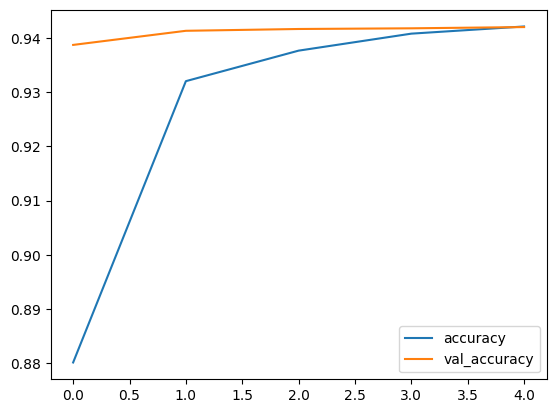

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='best')
plt.show()

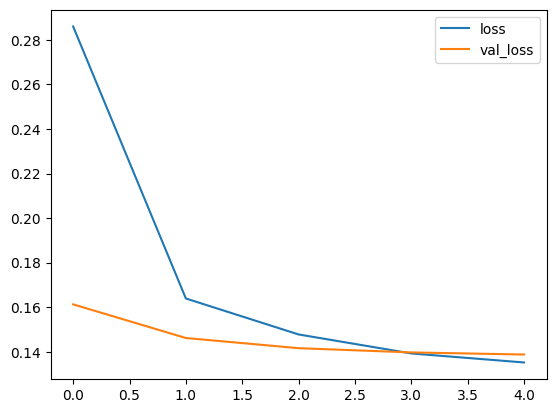

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'],loc='best')
plt.show()

### Confusion Matrix

<Axes: >

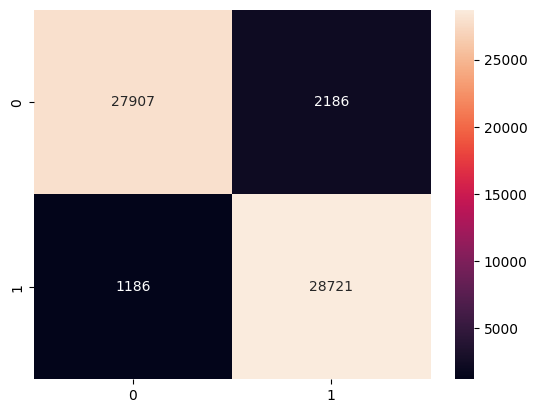

In [ ]:
from tensorflow.math import confusion_matrix
import seaborn as sns
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d')

### User Prediction

In [110]:
import numpy as np

tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = PorterStemmer()

url = input("Enter the URL: ")
url_token = tokenize(url)
url_vectorized = vectorizer.transform([url_token])
url_prob = model.predict(url_vectorized.toarray())
url_pred = np.where(url_prob > 0.6, 0, 1)
if url_pred == 0:
    print("Bad URL")
else:
    print("Good URL")
url_prob

# amazingdeals!!**.com
# ClickHereForDiscount.com

1/1 [==============================] - 0s 24ms/step
Bad URL


array([[0.79253507]], dtype=float32)

### Pickling

In [ ]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

INFO:tensorflow:Assets written to: ram://69867035-edf7-43ca-bad1-d3905d13baf7/assets
